# Learning Encodes Alignment within a Protein Family.

In [11]:
# Needed to import modules from helpers
import os
import sys
from io import StringIO

import esm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from Bio import AlignIO

current_dir = os.getcwd()
# Gehe einen Ordner nach oben
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)


from helpers import helper

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load ESM model to GPU

In [2]:
# kleineres Modell 'esm2_t6_8M_UR50D' zum testen
# verwendet 36-layer Transformer trained on UniParc" (ca. 670 Mio. Parameter ) im Paper.
model, alphabet = esm.pretrained.esm1_t34_670M_UR50S()
# model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")

Modell auf GPU geladen.


# Get Data

### Hypothesis 1:
Final hidden representations of a sequence encode information about the MSA it belongs to. Even if it never saw the MSA (Model learns to cluster sequences belonging to the same MSA together). MSA is a long expensive process which could be improved by this model.

### Method:

- Get Dataset (Pfam)
- compare the distribution of cosine similarities of representations between pairs of residues that are aligned in the family’s MSA background distribution of cosine similarities between unaligned pairs of residues.
- Compare with distributions befor learning (We need the embeddings befor pretraining (randomize model))
From paper: -	Using the collection of MSAs of structurally related sequences in Pfam (48), we compare the distribution of cosine similarities of representations between pairs of residues that are aligned in the family’s MSA to a background distribution of cosine similarities between unaligned pairs of residues


In [3]:
# Fetch the data. PF01010 (Response regulator receiver domain)
msa_data = helper.get_pfam_seed_by_id("PF01010")

if msa_data:
    # Parse using BioPython
    msa = AlignIO.read(StringIO(msa_data), "stockholm")

    # Verify
    print(f"\nSuccess! Loaded {msa[0].id}")
    print(f"Sequence count: {len(msa)}")
    print(f"Alignment length: {msa.get_alignment_length()}")
else:
    print("Family not found in the current Pfam release.")

Streaming Pfam database to find PF01010...
This may take 1-2 minutes as it searches the compressed stream.

Success! Loaded Q8HUX0_9ROSA/106-348
Sequence count: 76
Alignment length: 344


In [4]:
# Assuming your alignment object is named 'alignment'
# We extract the ID and convert the Seq object to a string
data = [{"id": record.id, "sequence": str(record.seq)} for record in msa]

df = pd.DataFrame(data)

# Preview
print(df.head())

                     id                                           sequence
0  Q8HUX0_9ROSA/106-348  RIYLLTFEGHLN------VHFQTYSGK--KNNLF--SSISLWG--K...
1   Q0MS80_9ROSA/77-329  RIYLLAFEGHLN------VYFQTYSGK--KSSSF--YSMSLWGKDK...
2  Q6JXE4_9ROSA/410-658  RIYLLTFEGHLN------VYCKTYSGK--KKRSV--YSISLWG--R...
3  Q6JX94_9ROSA/404-655  RIYLLTFEGHLN------FYFQTYSDK--KRSSV--YSISLWG--R...
4    NU5C_PELHO/448-688  RIYLLTFEGHLN------VHFRNYSGK--RSNSF--YSISLWG--N...


In [5]:
# Create a list where every sequence string is split into a list of characters
data = [list(str(record.seq)) for record in msa]

# Pass the IDs as the index
ids = [record.id for record in msa]

df = pd.DataFrame(data, index=ids)

# This results in columns 0 to 343 (since length is 344)
print(df.head())

                     0   1   2   3   4   5   6   7   8   9    ... 334 335 336  \
Q8HUX0_9ROSA/106-348   R   I   Y   L   L   T   F   E   G   H  ...   K   L   A   
Q0MS80_9ROSA/77-329    R   I   Y   L   L   A   F   E   G   H  ...   R   L   A   
Q6JXE4_9ROSA/410-658   R   I   Y   L   L   T   F   E   G   H  ...   L   F   S   
Q6JX94_9ROSA/404-655   R   I   Y   L   L   T   F   E   G   H  ...   I   L   S   
NU5C_PELHO/448-688     R   I   Y   L   L   T   F   E   G   H  ...   G   F   A   

                     337 338 339 340 341 342 343  
Q8HUX0_9ROSA/106-348   Q   L   T   H   F   F   D  
Q0MS80_9ROSA/77-329    E   L   T   H   F   F   D  
Q6JXE4_9ROSA/410-658   E   I   I   N   I   L   D  
Q6JX94_9ROSA/404-655   K   L   I   H   F   F   D  
NU5C_PELHO/448-688     E   F   T   H   F   F   D  

[5 rows x 344 columns]


### Prepare Data: Map MSA columns to Sequence Indices
The model cannot handle gaps ('.' or '-'), so we must remove them.
However, to check if residues are "aligned", we need to know their original column index.

In [6]:
clean_seqs, msa_mapping = helper.clean_and_map_msa(msa)

print(f"First clean sequence (len {len(clean_seqs[0])}): {clean_seqs[0][:20]}...")

Processing 76 sequences...
First clean sequence (len 243): RIYLLTFEGHLNVHFQTYSG...


### 2. Get Representations (Forward Pass)

In [7]:

token_reps_trained, token_reps_untrained = helper.forward_pass(clean_seqs, model, alphabet)

print("Forward passes complete.")

Processing 76 sequences in batches of 1...
Processing 76 sequences in batches of 1...
Forward passes complete.


### 3. Calculate Cosine Similarities

In [12]:
def get_cosine_similarities(msa, tokens, n_samples=50000, mode = "all" ,print_stats=False):

    clean_seq , msa_mapping = helper.clean_and_map_msa(msa)

    token_reps_trained, token_reps_untrained = tokens

    aligned_pairs = helper.sample_aligned_pairs(
    msa_mapping, num_samples=n_samples, msa=msa, mode=mode
)
    unaligned_pairs = helper.sample_unaligned_pairs(aligned_pairs, msa_mapping)

    msa_print = None
    if mode in ["distinct"]:
        msa_print = msa

# Calculate for Trained
    print("Calculating similarities for TRAINED model...")

    train_aligned_sim = helper.get_cosine_similarity(
    aligned_pairs, token_reps_trained, msa_mapping, msa_print
)
    train_unaligned_sim = helper.get_cosine_similarity(
    unaligned_pairs, token_reps_trained, msa_mapping,
)

# Calculate for Untrained
    print("Calculating similarities for UNTRAINED model...")
    untrain_aligned_sim = helper.get_cosine_similarity(
    aligned_pairs, token_reps_untrained, msa_mapping, msa_print
)
    untrain_unaligned_sim = helper.get_cosine_similarity(
    unaligned_pairs, token_reps_untrained, msa_mapping,
        
)
    if print_stats:
        print(
        f"Done. Collected {len(train_aligned_sim)} aligned and {len(train_unaligned_sim)} unaligned pairs."
    )

        print(
        f"{train_aligned_sim[:5]=}, \n{train_unaligned_sim[:5]=}, \n{untrain_aligned_sim[:5]=}, \n{untrain_unaligned_sim[:5]=}"
    )
        print(
        f"{len(train_aligned_sim)=}, {len(train_unaligned_sim)=}, {len(untrain_aligned_sim)=}, {len(untrain_unaligned_sim)=}"
    )
    return (
        train_aligned_sim,
        train_unaligned_sim,
        untrain_aligned_sim,
        untrain_unaligned_sim,
    )

train_aligned_all,  train_unaligned_all, untrain_aligned_all, untrain_unaligned_all = get_cosine_similarities(msa, tokens=(token_reps_trained, token_reps_untrained), n_samples=50000, mode = "all",print_stats=False)
train_aligned_ident,  train_unaligned_ident, untrain_aligned_ident, untrain_unaligned_ident = get_cosine_similarities(msa, tokens=(token_reps_trained, token_reps_untrained), n_samples=50000, mode = "identity",print_stats=False)
train_aligned_distinct,  train_unaligned_distinct, untrain_aligned_distinct, untrain_unaligned_distinct = get_cosine_similarities(msa, tokens=(token_reps_trained, token_reps_untrained), n_samples=50000, mode = "distinct",print_stats=False)

Processing 76 sequences...
all
Calculating similarities for TRAINED model...
Calculating similarities for UNTRAINED model...
Processing 76 sequences...
identity
Calculating similarities for TRAINED model...
Calculating similarities for UNTRAINED model...
Processing 76 sequences...
distinct
Calculating similarities for TRAINED model...
Calculating similarities for UNTRAINED model...


### Visualization

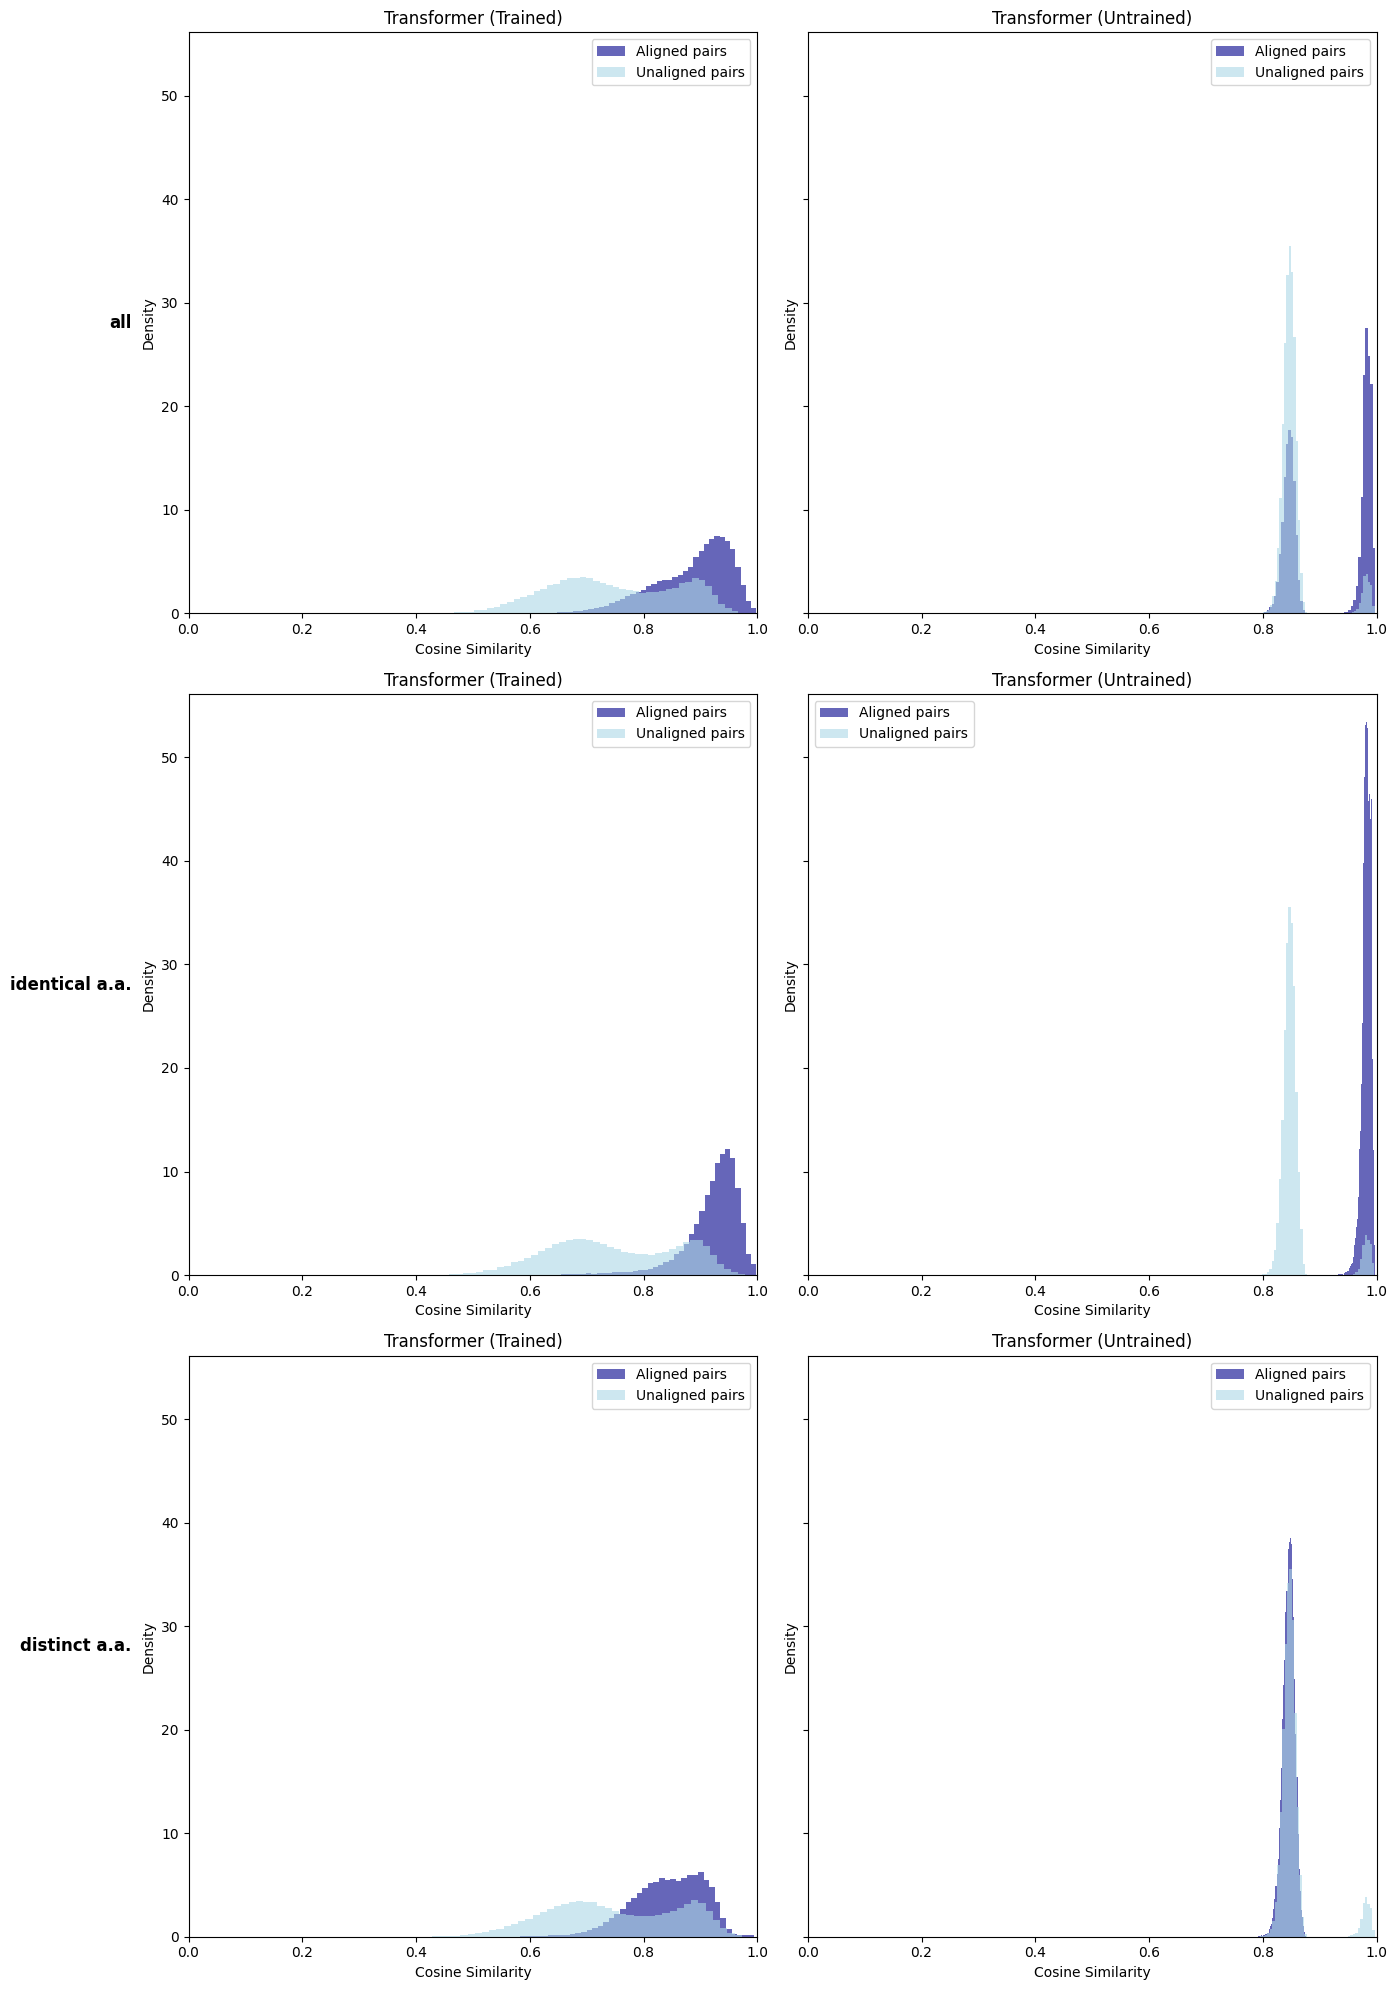

AUC Score (Discrimination between Aligned/Unaligned):
Trained Model:   0.8456
Untrained Model: 0.7174


(0.8455750276, 0.7174256788000001)

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(14, 20), sharey=True)

# Plot Trained
helper.plot_dist(axes[0][0], train_aligned_all, train_unaligned_all, "Transformer (Trained)")

# Plot Untrained
helper.plot_dist(
    axes[0][1], untrain_aligned_all, untrain_unaligned_all, "Transformer (Untrained)"
    
)


axes[0][0].annotate("all", xy=(-0.1, 0.5), xycoords='axes fraction',
                ha='right', va='center', size='large', weight='bold')


helper.plot_dist(axes[1][0], train_aligned_ident, train_unaligned_ident, "Transformer (Trained)")

# Plot Untrained
helper.plot_dist(
    axes[1][1], untrain_aligned_ident, untrain_unaligned_ident, "Transformer (Untrained)"
    
    
)

axes[1][0].annotate("identical a.a.", xy=(-0.1, 0.5), xycoords='axes fraction',
                ha='right', va='center', size='large', weight='bold')


helper.plot_dist(axes[2][0], train_aligned_distinct, train_unaligned_distinct, "Transformer (Trained)")

# Plot Untrained
helper.plot_dist(
    axes[2][1], untrain_aligned_distinct, untrain_unaligned_distinct, "Transformer (Untrained)"
)

axes[2][0].annotate("distinct a.a.", xy=(-0.1, 0.5), xycoords='axes fraction',
                ha='right', va='center', size='large', weight='bold')

plt.tight_layout()
plt.show()



helper.get_auc(
    train_aligned_all,
    train_unaligned_all,
    untrain_aligned_all,
    untrain_unaligned_all,
    print_stats=True,
)

In [ ]:
import pickle
import gzip
if "families" not in locals() and "families" not in globals():
    with gzip.open("../data/pfam_filtered_families.pkl.gz", "rb") as f:
        families = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/pfam_filtered_families.pkl.gz'

In [ ]:
print(families[0][0].seq.count('-'))
print(len(families[0][0].seq ))

In [ ]:
from tqdm import tqdm
import random
import numpy as np
%autoreload

trained_results = []
untrained_results = []

def get_128_seq(msa):
    msa = list(msa)
    n_samples = min(128, len(msa))
    return random.sample(msa, n_samples)   

for family in tqdm(families):

    msa = get_128_seq(family)

    clean_seqs, msa_mapping = helper.clean_and_map_msa(msa)
    token_reps_trained, token_reps_untrained = helper.forward_pass(clean_seqs, model=model, alphabet=alphabet)

    train_aligned_sim,  train_unaligned_sim, untrain_aligned_sim, untrain_unaligned_sim = get_cosine_similarities(msa, tokens=(token_reps_trained, token_reps_untrained), n_samples=50000, mode = "all", print_stats=False)
    
    trained_auc, untrained_auc = helper.get_auc(
        train_aligned_sim,
        train_unaligned_sim,
        untrain_aligned_sim,
        untrain_unaligned_sim,
    )
    trained_results.append(trained_auc)
    untrained_results.append(untrained_auc)

print("Experiments complete.")
print(f"average Trained AUCs: {np.mean(np.array(trained_results)) }")
print(f"average Untrained AUCs: {np.mean(np.array(untrained_results)) }")
# Save results

In [ ]:
print(np.array(trained_results).mean())
print(np.array(untrained_results).mean())